In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cv2
from scipy.fft import fft2, ifft2
from sklearn.cluster import KMeans

In [2]:
warnings.filterwarnings("ignore")

## 读取raw文件、显示热图

In [3]:
def read_raw(file_root='cube_20221028_104439\ENVI_cube_20221028_104439.raw'):
    """
    读取raw文件，转换成10*1024*1280的数组
    """
    width = 1280
    height = 1024
    channels = 10
    raw_image = np.fromfile(file_root, dtype=np.float16)
    image = raw_image.reshape((channels, height, width))
    image = image * 1.5e6
    
    return image 

In [4]:
def revise_raw(image):
    """
    将raw的值映射至1-7000，并让每个通道相加
    """
    image = image * 1e1
    image = np.sum(image, axis=0)
    
    return image

In [5]:
def show_heat_map(data = np.random.rand(1024, 1280), name='original'):
    """
    绘制热图,配置参数
    """
    
    # 定义自定义的颜色映射，从暗蓝色到绿色再到黄色，并反转颜色顺序
    cmap = ListedColormap(list(reversed(plt.cm.YlGnBu(np.linspace(0, 1, 256)))))
    # 绘制热图，并指定颜色映射和插值方式
    plt.imshow(data, cmap=cmap, interpolation='bilinear')
    plt.clim(0, 7000)
    # 添加颜色条
    plt.colorbar()

    # 添加标题和标签
    plt.title(name)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

    # 显示图像
    plt.show()
    

## 评价指标:使用不同通道的目标区域的平均面积重合度(mIOU)
### 1、计算所有通道的目标区域面积以及位置，目标区域指的是花生所在区域
### 2、选取基准通道，基准通道指目标区域面积最小的通道
### 3、计算所有通道与基准通道的IOU，之后求平均值，即为mIOU

In [6]:
def calculate_IOU(image1, image2):
    intersection = np.logical_and(image1, image2)
    union = np.logical_or(image1, image2)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [7]:
def calculate_mIOU(img):
    a = 1587120
    count = []
    img_lst = []
    for i, image in enumerate(img):
        # 将图像转换为二维数组
        pixels = image.reshape(1, -1)
        pixels = pixels.reshape(-1, 1)
        # 使用K均值聚类进行图像聚类
        kmeans = KMeans(n_clusters=2)  # K是聚类的数量
        kmeans.fit(pixels)
        # 获取聚类标签和聚类中心
        labels = kmeans.labels_
        
        # 将聚类结果转换为图像形式
        segmented_image = labels.reshape(1024, 1280)
        # 根据聚类结果标记多数类和少数类
        majority_class_label = np.argmax(np.bincount(labels))
        minority_class_label = 1 - majority_class_label
        segmented_image[segmented_image == majority_class_label] = 0
        segmented_image[segmented_image == minority_class_label] = 1
        
        img_lst.append(segmented_image)
        
        # 计算每个类别的个数
        counts = np.bincount(labels)
        count.append(min(counts))

    idx = count.index(min(count))
    IOU = 0
    for img in img_lst:
        IOU += calculate_IOU(img, img_lst[idx])
    return IOU/10

## 像素对齐
### 1、选取基准通道，以花生面积最小的通道为基准通道
### 2、计算其余通道与基准通道之间的SIFT特征
### 3、特征匹配与仿射变换

In [8]:
def align_channels(image):

    reference_channel = image[0]
    aligned_data = np.zeros_like(image)

    # 创建SIFT对象
    sift = cv2.SIFT_create()

    # 对每个通道进行对齐和重影修复
    for channel in range(image.shape[0]):
        current_channel = image[channel]

        # 将图像数据类型转换为np.uint8
        reference_channel = (reference_channel*5).astype(np.uint8)
        current_channel = (current_channel*5).astype(np.uint8)

        # 使用SIFT特征检测和描述符提取
        keypoints_ref, descriptors_ref = sift.detectAndCompute(reference_channel, None)
        keypoints_cur, descriptors_cur = sift.detectAndCompute(current_channel, None)

        # 使用FLANN匹配器进行特征匹配
        matcher = cv2.FlannBasedMatcher()
        matches = matcher.match(descriptors_ref, descriptors_cur)

        # 根据匹配结果计算图像间的仿射变换矩阵
        src_pts = np.float32([keypoints_ref[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_cur[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        M, _ = cv2.estimateAffinePartial2D(src_pts, dst_pts)

        # 将当前通道的图像根据仿射变换矩阵进行像素对齐
        aligned_image = cv2.warpAffine(current_channel, M, reference_channel.shape[::-1])

        # 将对齐后的图像保存到输出图像数组中
        aligned_data[channel] = aligned_image.astype(np.float32)/5

    return aligned_data


In [11]:
def main():
    file_list = ['cube_20221028_104439\ENVI_cube_20221028_104439.raw', 'cube_20221028_104126\ENVI_cube_20221028_104126.raw']
    
    for file in file_list:
        # 原始图像
        img = read_raw(file)
        original_mIOU = calculate_mIOU(img)
        original_img = revise_raw(img)
        show_heat_map(original_img)
        
        final_img = align_channels(img)
        final_mIOU = calculate_mIOU(final_img)
        final_img = final_img *5
        final_img = revise_raw(final_img)
        show_heat_map(final_img, name='final')
        
        print('原始图片的mIOU：',original_mIOU)
        print('像素对齐的mIOU：',final_mIOU)
        print('__________________________________________________________')
        

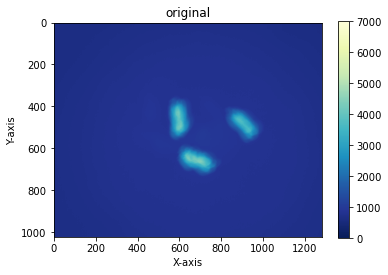

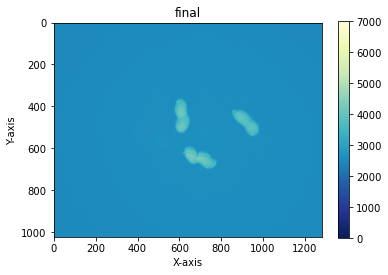

原始图片的mIOU： 0.33092077416648347
像素对齐的mIOU： 0.2
__________________________________________________________


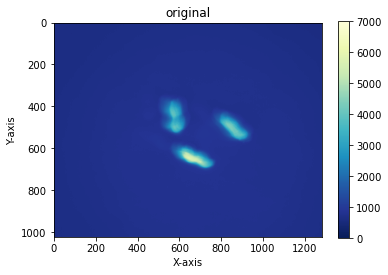

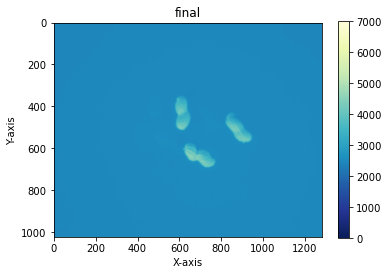

原始图片的mIOU： 0.6012549908383867
像素对齐的mIOU： 0.10002949976821611
__________________________________________________________


In [12]:
if __name__ == '__main__':
    main()